<a href="https://colab.research.google.com/github/instrat-pl/pypsa-pl/blob/main/notebooks/pypsa_pl_mini_capex_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyPSA-PL-mini: OPEX+CAPEX, power system

Simplified energy model for rapid testing and education.

Example of joint OPEX and CAPEX optimisation for the power system.

Version 1.0

This notebook is released under [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact person:** Patryk Kubiczek (patryk.kubiczek@instrat.pl)

## How to use it?

**Start by making your own copy of this notebook (File > Save a copy in Drive).** This notebook, containing an application of the  PyPSA-PL-mini model, is synchronised with the GitHub repository https://github.com/instrat-pl/pypsa-pl. To play with the model, create your own copy of this notebook. 

Run the "Configuration" cells which will clone the PyPSA-PL repository into your Google Colab space and which will install all the required libraries. This might take up to a few minutes. After the configuration is finished, you can proceed to experiment with PyPSA-PL-mini. Have fun!

## Configuration (run each cell just once)

In [1]:
import sys
import os

# Optionally install pl_PL.UTF-8 locale in Google Colab
# Source: https://stackoverflow.com/questions/67045349/change-locale-for-google-colab

skip_installing_pl_locale = True

if "google.colab" in sys.modules and not skip_installing_pl_locale:
  # Install pl_PL
  !/usr/share/locales/install-language-pack pl_PL.UTF-8
  !dpkg-reconfigure locales
    
  # Restart Python process to pick up the new locales
  os.kill(os.getpid(), 9)

In [2]:
import sys
import os
from pathlib import Path

instrat_user = False
force_installation = False

if "google.colab" in sys.modules:

  %cd "/content"

  if instrat_user:  
    
    from google.colab import drive
    root = "/content/drive"
    drive.mount(root)

    def project_dir(*path):
      return Path(root, "MyDrive", "Colab", "PyPSA-PL-mini", *path)

  else:
    
    from google.colab import userdata
    # ghtoken = userdata.get("GHTOKEN")

    !rm -rf pypsa-pl
    # !git clone https://{ghtoken}@github.com/instrat-pl/pypsa-pl.git
    !git clone https://github.com/instrat-pl/pypsa-pl.git

    def project_dir(*path):
      return Path("/content", "pypsa-pl", *path)

  %cd {str(project_dir())}

  if not instrat_user or force_installation:
    !pip install poetry --quiet
    !poetry config virtualenvs.in-project false
    !poetry config virtualenvs.path {str(project_dir("venv"))}
    !poetry install --no-ansi
    # ipywidgets have to be downgraded in Google Colab
    !poetry add ipywidgets@7.7.2 --no-ansi
    # Download and install Work Sans font
    !mkdir fonts
    %cd fonts  
    !wget https://github.com/weiweihuanghuang/Work-Sans/raw/master/fonts/ttf/WorkSans-Regular.ttf
    !wget https://github.com/weiweihuanghuang/Work-Sans/raw/master/fonts/ttf/WorkSans-Medium.ttf
    from matplotlib import font_manager
    font_files = ["WorkSans-Regular.ttf", "WorkSans-Medium.ttf"]
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)
    %cd ..

  v = f"{sys.version_info.major}.{sys.version_info.minor}"
  venv_location = !poetry env info -p
  VENV_PATH = os.path.join(venv_location[0], "lib", f"python{v}", "site-packages")
  sys.path.insert(0, VENV_PATH)  
  
  SRC_PATH = str(project_dir("src"))
  sys.path.insert(0, SRC_PATH)

else:
  %load_ext autoreload
  %autoreload 2

import pypsa_pl.config

## Power system model

### Specify parameters

In [3]:
params = {
    # Run name and year
    "run_name": "pypsa_pl_mini_capex_power",
    "year": 2023,
    # Input data
    "technology_carrier_definitions": "mini",
    "technology_cost_data": "instrat_2024",
    "installed_capacity": "historical_totals",
    "annual_energy_flows": "historical",
    "capacity_utilisation": "historical",
    "capacity_addition_potentials": "instrat_projection",  # irrelevant in this example
    "timeseries": "mini",
    # CO2 emissions
    "co2_emissions": None,  # no limit on CO2 emissions
    # Weather year
    "weather_year": 2012,
    # Other assumptions
    "discount_rate": 0.045,
    "investment_cost_start_year": 2021,
    "invest_from_zero": True,
    "optimise_industrial_capacities": False,
    "investment_technologies": [
        "wind onshore",
        "solar PV ground",
        # "nuclear power large",
        "natural gas power CCGT",
        "natural gas power peaker",
        # "hard coal power SC",
        # "lignite power SC",
        "battery large power",
        "battery large charger",
        "battery large storage",
    ],
    "retirement_technologies": [
        # "hard coal power old",
        # "lignite power old",
        # "hard coal power SC",
        # "lignite power SC",
        # "biomass wood power",
    ],
    "constrained_energy_flows": [],
    "reoptimise_with_fixed_capacities": True,  # if True, only OPEX determines marginal prices
    # CHP behaviour
    "fix_public_chp": True,
    "fix_industrial_chp": True,
    "share_space_heating": 0.75,
    # Electricity sector
    "prosumer_self_consumption": 0.2,
    "p_min_synchronous": 0,  # irrelevant in this example - we set p_min_pu for thermal power plants
    "synchronous_carriers": [],
    # Technical details
    "inf": 100000,
    "space_heating_utilisation": 0.1,  # irrelevant in this example
    "water_heating_utilisation": 1,  # irrelevant in this example
    "other_heating_utilisation": 1,  # irrelevant in this example
    "heat_capacity_utilisation": 0.2,  # irrelevant in this example
    "light_vehicle_mobility_utilisation": 0.021,  # irrelevant in this example
    "hydrogen_utilisation": 1,  # irrelevant in this example
    "reverse_links": True,
    "solver": "highs",
    "solver_tolerance": 1e-6,
}

### Prepare inputs


In [4]:
import logging
import numpy as np
from pypsa_pl.build_network import load_and_preprocess_inputs


def custom_operation(inputs, params):

    def add_qualifier_to_technology(df, technology, qualifier):
        df.loc[df["technology"] == technology, "qualifier"] = qualifier
        return df

    # Identify solar PV roof as prosumer electricity source
    inputs["installed_capacity"] = add_qualifier_to_technology(
        inputs["installed_capacity"],
        "solar PV roof",
        "prosumer",
    )

    def remove_capacities(df, technologies):
        df = df[~df["technology"].isin(technologies)]
        return df

    # Do not model cross border electricity flows in this simplified example
    inputs["installed_capacity"] = remove_capacities(
        inputs["installed_capacity"],
        technologies=[
            "electricity export AC",
            "electricity import AC",
            "electricity export DC",
            "electricity import DC",
        ],
    )

    def subtract_grid_losses(df_flow):
        distribution_loss = 0.04

        # Subtract electricity grid losses
        is_electricity_final_use = df_flow["carrier"] == "electricity final use"
        df_flow.loc[is_electricity_final_use, "value"] *= 1 - distribution_loss
        logging.info(
            f"Subtracting {(distribution_loss * 100):.0f}% electricity distribution loss"
        )

        df_flow["value"] = df_flow["value"].round(1)

        return df_flow

    # The input electricity final use includes losses, so we need to subtract them
    inputs["annual_energy_flows"] = subtract_grid_losses(inputs["annual_energy_flows"])

    def add_new_capacities(df, technologies):
        df = df.set_index("name")
        for technology in technologies:
            area = "PL"
            area2 = np.nan
            qualifier = np.nan
            build_year = params["year"]
            retire_year = np.nan
            cumulative = False
            nom = 0
            df.loc[f"PL {technology} new"] = [
                area,
                area2,
                technology,
                qualifier,
                build_year,
                retire_year,
                cumulative,
                nom,
            ]
        df = df.reset_index()
        return df

    # Add candidate capacities to extend
    inputs["installed_capacity"] = add_new_capacities(
        inputs["installed_capacity"],
        technologies=[
            "wind onshore",
            "solar PV ground",
            "nuclear power large",
            "natural gas power CCGT",
            "natural gas power peaker",
            "hard coal power SC",
            "lignite power SC",
            "battery large power",
            "battery large charger",
            "battery large storage",
        ],
    )

    def add_p_min_pu_constraint(df, technology, qualifier="", p_min_pu=0):
        df["qualifier"] = df["qualifier"].fillna("")
        df = df.set_index(["area", "technology", "qualifier", "year", "parameter"])
        df.loc[("PL", technology, qualifier, params["year"], "p_min_pu"), "value"] = (
            p_min_pu
        )
        df = df.reset_index()
        df["qualifier"] = df["qualifier"].replace("", np.nan)
        return df

    # Add 50% minimum load constraint for nuclear power plants
    inputs["capacity_utilisation"] = add_p_min_pu_constraint(
        inputs["capacity_utilisation"], "nuclear power large", p_min_pu=0.5
    )

    return inputs


inputs = load_and_preprocess_inputs(params, custom_operation=custom_operation)

2024-11-09 00:15:53 [INFO] NumExpr defaulting to 8 threads.
2024-11-09 00:15:57 [INFO] Subtracting 4% electricity distribution loss


In [5]:
name = "technology_carrier_definitions"
# name = "technology_cost_data"
# name = "installed_capacity"
# name = "annual_energy_flows"
# name = "capacity_utilisation"
# name = "co2_cost"
# name = "final_use"

inputs[name].head()

,technology,carrier,aggregation,parent,bus_carrier,input_carrier,output_carrier,output2_carrier,component,color,order
0,electricity final use,electricity final use,electricity final use,NaN,NaN,electricity out,NaN,NaN,Generator,#b6b6b7,1
1,hard coal supply,hard coal supply,hard coal supply,NaN,NaN,NaN,hard coal,NaN,Generator,#b5c6cf,110
2,hard coal power old,hard coal power,hard coal power,NaN,NaN,hard coal,electricity in,NaN,Link,#b5c6cf,111
3,hard coal power SC,hard coal power,hard coal power,NaN,NaN,hard coal,electricity in,NaN,Link,#b5c6cf,112
4,hard coal CHP,hard coal CHP,hard coal CHP,NaN,NaN,hard coal,electricity in,NaN,Link,#b5c6cf,113


### Create PyPSA network

In [6]:
from pypsa_pl.build_network import create_custom_network

network = create_custom_network(params)

network

Empty PyPSA Network 'pypsa_pl_mini_capex_power'
Components: none
Snapshots: 1

### Add snapshots

In [7]:
from pypsa_pl.build_network import add_snapshots

add_snapshots(network, params)

network.snapshots

Index(['2023-03-09 00:00:00', '2023-03-09 01:00:00', '2023-03-09 02:00:00',
       '2023-03-09 03:00:00', '2023-03-09 04:00:00', '2023-03-09 05:00:00',
       '2023-03-09 06:00:00', '2023-03-09 07:00:00', '2023-03-09 08:00:00',
       '2023-03-09 09:00:00',
       ...
       '2023-11-01 14:00:00', '2023-11-01 15:00:00', '2023-11-01 16:00:00',
       '2023-11-01 17:00:00', '2023-11-01 18:00:00', '2023-11-01 19:00:00',
       '2023-11-01 20:00:00', '2023-11-01 21:00:00', '2023-11-01 22:00:00',
       '2023-11-01 23:00:00'],
      dtype='object', name='snapshot', length=672)

### Add carriers

In [8]:
from pypsa_pl.build_network import add_carriers

add_carriers(network, inputs, params)

network.carriers

,color,order,aggregation,co2_emissions,nice_name,max_growth,max_relative_growth
Carrier,,,,,,,
DSR reduction,#1b1c1e,291,DSR,NaN,,inf,0.0
battery large charger,#458aff,242,battery large,NaN,,inf,0.0
battery large power,#458aff,241,battery large,NaN,,inf,0.0
battery large storage,#458aff,240,battery large,NaN,,inf,0.0
biogas CHP,#816d66,183,biogas CHP,NaN,,inf,0.0
biogas production,#816d66,181,biogas production,NaN,,inf,0.0
biogas substrate supply,#816d66,180,biogas substrate supply,NaN,,inf,0.0
biomass agriculture CHP,#ab9d99,171,biomass CHP,NaN,,inf,0.0
biomass agriculture supply,#ab9d99,170,biomass supply,NaN,,inf,0.0


### Add buses

In [9]:
from pypsa_pl.build_network import add_buses_and_areas

add_buses_and_areas(network, inputs, params)

network.buses

,area,carrier,qualifier,v_nom,type,x,y,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,,,
PL battery large electricity,PL,battery large electricity,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL biogas,PL,biogas,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL biogas substrate,PL,biogas substrate,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL biomass wood,PL,biomass wood,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL electricity in,PL,electricity in,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL electricity out,PL,electricity out,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL hard coal,PL,hard coal,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL hydro PSH electricity,PL,hydro PSH electricity,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,
PL lignite,PL,lignite,,1.0,,0.0,0.0,,1.0,0.0,inf,PQ,,


### Add generating, consuming, and storing capacity (generators, links, stores)

#### Process installed capacity data and specify the relevant attributes

In [10]:
from pypsa_pl.build_network import process_capacity_data

df_cap = process_capacity_data(inputs, params)

df_cap.head()

,name,area,area2,technology,qualifier,build_year,retire_year,cumulative,nom,carrier,...,e_nom_max,p_set,p_set_annual,p_max_pu,p_min_pu,p_set_pu_annual,e_min_pu,e_max_pu,p_min_pu_annual,parent
0,PL battery large charger 2023,PL,PL,battery large charger,NaN,2023,2023.0,True,140.0,battery large charger,...,NaN,NaN,NaN,1.0,0.0,NaN,0.0,1.0,0.0,NaN
46,PL battery large charger new,PL,PL,battery large charger,NaN,2023,2042.0,False,0.0,battery large charger,...,NaN,NaN,NaN,1.0,0.0,NaN,0.0,1.0,0.0,NaN
1,PL battery large power 2023,PL,PL,battery large power,NaN,2023,2023.0,True,150.0,battery large power,...,NaN,NaN,NaN,1.0,0.0,NaN,0.0,1.0,0.0,NaN
45,PL battery large power new,PL,PL,battery large power,NaN,2023,2042.0,False,0.0,battery large power,...,NaN,NaN,NaN,1.0,0.0,NaN,0.0,1.0,0.0,NaN
2,PL battery large storage 2023,PL,NaN,battery large storage,NaN,2023,2023.0,True,600.0,battery large storage,...,600.0,NaN,NaN,1.0,0.0,NaN,0.0,1.0,0.0,NaN


#### Specify which attributes are time dependent

In [11]:
from pypsa_pl.define_time_dependent_attributes import (
    define_time_dependent_attributes,
)


df_attr_t = define_time_dependent_attributes(df_cap, params)

df_attr_t

,carrier,technology,qualifier,attribute,profile_type
0,electricity final use,electricity final use,none,p_set,electricity final use load profile
1,biogas CHP,biogas CHP,public,p_set,public heat final use load profile
2,biomass wood CHP,biomass wood CHP,public,p_set,public heat final use load profile
3,hard coal CHP,hard coal CHP,public,p_set,public heat final use load profile
4,natural gas CHP,natural gas CHP CCGT old,public,p_set,public heat final use load profile
5,natural gas CHP,natural gas CHP CCGT,public,p_set,public heat final use load profile
6,natural gas CHP,natural gas CHP old,public,p_set,public heat final use load profile
7,solar PV ground,solar PV ground,none,p_max_pu,vres availability profile
8,solar PV roof,solar PV roof,prosumer,p_max_pu,vres availability profile
9,wind onshore,wind onshore,none,p_max_pu,vres availability profile


#### Create actual components and fill them with data

In [12]:
from pypsa_pl.build_network import add_capacities

add_capacities(network, df_cap, df_attr_t, params)

In [13]:
network.generators.head()

,bus,area,carrier,technology,qualifier,aggregation,p_nom,p_nom_extendable,p_nom_min,p_nom_max,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
PL biogas substrate supply 2023,PL biogas substrate,PL,biogas substrate supply,biogas substrate supply,,biogas substrate supply,100000.0,False,100000.0,100000.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL biomass wood supply 2023,PL biomass wood,PL,biomass wood supply,biomass wood supply,,biomass supply,100000.0,False,100000.0,100000.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL electricity final use 2023,PL electricity out,PL,electricity final use,electricity final use,,electricity final use,100000.0,False,100000.0,100000.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL hard coal supply 2023,PL hard coal,PL,hard coal supply,hard coal supply,,hard coal supply,100000.0,False,100000.0,100000.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
PL hydro ROR 2023,PL electricity in,PL,hydro ROR,hydro ROR,,hydro ROR,600.0,False,600.0,600.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [14]:
network.generators[["lifetime", "fixed_cost", "investment_cost", "annual_investment_cost", "capital_cost", "p_nom_extendable", "p_nom_min", "p_nom_max"]]

,lifetime,fixed_cost,investment_cost,annual_investment_cost,capital_cost,p_nom_extendable,p_nom_min,p_nom_max
Generator,,,,,,,,
PL biogas substrate supply 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0
PL biomass wood supply 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0
PL electricity final use 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0
PL hard coal supply 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0
PL hydro ROR 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,600.0,600.0
PL lignite supply 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0
PL natural gas supply 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0
PL nuclear power large new,60.0,1100000.0,45000000.0,2.180442e+06,3.280442e+06,False,0.0,0.0
PL other fuel supply 2023,1.0,0.0,0.0,0.000000e+00,0.000000e+00,False,100000.0,100000.0


In [15]:
network.links.head()

,bus0,bus1,bus2,area,area2,carrier,technology,qualifier,aggregation,p_nom,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
PL battery large charger 2023,PL battery large electricity,PL electricity out,,PL,PL,battery large charger,battery large charger,,battery large,140.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL battery large charger new,PL battery large electricity,PL electricity out,,PL,PL,battery large charger,battery large charger,,battery large,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL battery large power 2023,PL electricity in,PL battery large electricity,,PL,PL,battery large power,battery large power,,battery large,150.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL battery large power new,PL electricity in,PL battery large electricity,,PL,PL,battery large power,battery large power,,battery large,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PL biogas CHP industrial 2023,PL electricity in,PL biogas,,PL,PL,biogas CHP,biogas CHP,industrial,biogas CHP,70.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [16]:
network.links[["lifetime", "fixed_cost", "investment_cost", "annual_investment_cost", "capital_cost", "p_nom_extendable", "p_nom_min", "p_nom_max"]]

,lifetime,fixed_cost,investment_cost,annual_investment_cost,capital_cost,p_nom_extendable,p_nom_min,p_nom_max
Link,,,,,,,,
PL battery large charger 2023,1.0,0.0,0.0,0.000000,0.000000e+00,False,140.0,140.0
PL battery large charger new,20.0,0.0,0.0,0.000000,0.000000e+00,True,0.0,inf
PL battery large power 2023,1.0,3400.0,0.0,0.000000,3.400000e+03,False,150.0,150.0
PL battery large power new,20.0,3400.0,1700000.0,130689.445351,1.340894e+05,True,0.0,inf
PL biogas CHP industrial 2023,1.0,62000.0,0.0,0.000000,6.200000e+04,False,70.0,70.0
PL biogas CHP public 2023,1.0,62000.0,0.0,0.000000,6.200000e+04,False,210.0,210.0
PL biogas production industrial 2023,1.0,350000.0,0.0,0.000000,3.500000e+05,False,180.0,180.0
PL biogas production public 2023,1.0,350000.0,0.0,0.000000,3.500000e+05,False,520.0,520.0
PL biomass wood CHP industrial 2023,1.0,940000.0,0.0,0.000000,9.400000e+05,False,200.0,200.0


In [17]:
network.stores.head()

,bus,area,carrier,technology,qualifier,aggregation,e_nom,e_nom_extendable,e_nom_min,e_nom_max,...,type,e_nom_mod,e_initial,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,marginal_cost_quadratic,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
PL battery large storage 2023,PL battery large electricity,PL,battery large storage,battery large storage,,battery large,600.0,False,600.0,600.0,...,,0.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0
PL battery large storage new,PL battery large electricity,PL,battery large storage,battery large storage,,battery large,0.0,True,0.0,inf,...,,0.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0
PL hydro PSH storage 2023,PL hydro PSH electricity,PL,hydro PSH storage,hydro PSH storage,,hydro PSH,8470.0,False,8470.0,8470.0,...,,0.0,0.0,False,True,0.0,0.0,1.0,0.0,0.0


In [18]:
network.stores[["lifetime", "fixed_cost", "investment_cost", "annual_investment_cost", "capital_cost", "e_nom_extendable", "e_nom_min", "e_nom_max"]]

,lifetime,fixed_cost,investment_cost,annual_investment_cost,capital_cost,e_nom_extendable,e_nom_min,e_nom_max
Store,,,,,,,,
PL battery large storage 2023,1.0,0.0,0.0,0.000000,0.000000,False,600.0,600.0
PL battery large storage new,20.0,0.0,1500000.0,115314.216486,115314.216486,True,0.0,inf
PL hydro PSH storage 2023,1.0,0.0,0.0,0.000000,0.000000,False,8470.0,8470.0


### Add flow constraints

In [19]:
from pypsa_pl.build_network import add_energy_flow_constraints

add_energy_flow_constraints(network, inputs, params)

# No flow constraints are added by default
network.global_constraints

,type,investment_period,area,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,,


### Save input network

In [20]:
from pypsa_pl.config import data_dir

os.makedirs(data_dir("runs", params["run_name"]), exist_ok=True)
network.export_to_csv_folder(data_dir("runs", params["run_name"], "input_network"))

2024-11-09 00:16:03 [INFO] Exported network input_network has stores, buses, carriers, links, generators, areas


### Solve the model

In [21]:
from pypsa_pl.optimise_network import optimise_network

network_non_fixed, network = optimise_network(network, params)

2024-11-09 00:16:03 [INFO] Repeating time-series for each investment period and converting snapshots to a pandas.MultiIndex.


2024-11-09 00:16:11 [INFO]  Solve problem using Highs solver
2024-11-09 00:16:11 [INFO] Solver options:
 - threads: 4
 - solver: ipm
 - run_crossover: off
 - small_matrix_value: 1e-07
 - large_matrix_value: 1000000000000.0
 - primal_feasibility_tolerance: 9.999999999999999e-06
 - dual_feasibility_tolerance: 9.999999999999999e-06
 - ipm_optimality_tolerance: 1e-06
 - parallel: on
 - random_seed: 0
2024-11-09 00:16:12 [INFO] Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 23.17it/s]
2024-11-09 00:16:14 [INFO]  Writing time: 2.24s
2024-11-09 00:16:16 [INFO] Log file at /tmp/highs.log.


Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 7e+02]
  Cost   [3e+01, 6e+05]
  Bound  [0e+00, 0e+00]
  RHS    [6e+00, 3e+05]
Presolving model
9105 rows, 17226 cols, 38111 nonzeros  0s
7089 rows, 15210 cols, 34079 nonzeros  0s
7089 rows, 14174 cols, 32371 nonzeros  0s
Presolve : Reductions: rows 7089(-76925); columns 14174(-20105); elements 32371(-109795)
Solving the presolved LP
IPX model has 7089 rows, 14174 columns and 32371 nonzeros
Input
    Number of variables:                                14174
    Number of free variables:                           0
    Number of constraints:                              7089
    Number of equality constraints:                     3360
    Number of matrix entries:                           32371
    Matrix range:                                       [1e-03, 7e+02]
    RHS range:                                          [2e+03, 2e+05]
    Objective range:       

2024-11-09 00:16:19 [INFO]  Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34279 primals, 84014 duals
Objective: 7.31e+10
Solver model: available
Solver message: optimal



e columns:                            6
    Range of scaling factors:                           [6.25e-02, 1.00e+00]
IPX version 1.0
Interior Point Solve
 Iter     P.res    D.res            P.obj           D.obj        mu     Time
   0   4.37e+04 4.17e+04   2.96204802e+10 -6.34955852e+12  2.01e+09       0s
   1   2.43e+04 4.06e+04   1.00796855e+11 -6.25542636e+12  1.43e+09       0s
   2   3.51e+03 1.45e+04   2.85816767e+11 -3.58735108e+12  3.64e+08       0s
   3   1.03e+03 8.19e+02   2.70667712e+11 -9.51550381e+11  8.21e+07       0s
   4   3.61e+02 6.80e+01   1.93551482e+11 -1.60441612e+11  2.01e+07       0s
   5   9.97e+01 3.03e+00   1.06836259e+11 -3.38636523e+10  6.31e+06       0s
   6   5.37e+01 8.89e-01   8.95465045e+10  9.31523500e+09  3.50e+06       0s
   7   2.80e+01 2.68e-01   7.58772575e+10  3.39583375e+10  1.82e+06       1s
 Constructing starting basis...
   8   1.75e+01 7.76e-02   6.91451546e+10  4.47110081e+10  9.22e+05       1s
   9   8.63e+00 2.58e-02   6.30585699e+10  4

2024-11-09 00:16:19 [INFO] The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Link-p_set, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
2024-11-09 00:16:20 [INFO] Repeating optimization with optimal capacities fixed...
2024-11-09 00:16:24 [INFO]  Solve problem using Highs solver
2024-11-09 00:16:24 [INFO] Solver options:
 - threads: 4
 - solver: ipm
 - run_crossover: off
 - small_matrix_value: 1e-07
 - large_matrix_value: 1000000000000.0
 - primal_feasibility_tolerance: 9.999999999999999e-05
 - dual_feasibility_tolerance: 9.999999999999999e-05
 - ipm_optimality_tolerance: 9.999999999999999e-06
 - parallel: on
 - random_seed: 0
2024-11-09 00:16:25 [INFO] Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 1

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 4e+00]
  Cost   [3e+01, 4e+03]
  Bound  [0e+00, 0e+00]
  RHS    [1e-05, 3e+05]
Presolving model
4709 rows, 16509 cols, 28605 nonzeros  0s
2021 rows, 13821 cols, 23229 nonzeros  0s
2015 rows, 11017 cols, 18360 nonzeros  0s
2001 rows, 10814 cols, 18041 nonzeros  0s
Presolve : Reductions: rows 2001(-82006); columns 10814(-23458); elements 18041(-119719)
Solving the presolved LP
IPX model has 2001 rows, 10814 columns and 18041 nonzeros
Input
    Number of variables:                                10814
    Number of free variables:                           0
    Number of constraints:                              2001
    Number of equality constraints:                     1997
    Number of matrix entries:                           18041
    Matrix range:                                       [1e+00, 1e+00]
    RHS range:                                          

2024-11-09 00:16:29 [INFO]  Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 34272 primals, 84007 duals
Objective: 6.94e+10
Solver model: available
Solver message: optimal



dual residual (abs/rel):          1.26e-06 / 8.36e-11
    interior solution objective gap (abs/rel):          1.67e+05 / 4.21e-06
Ipx: IPM       optimal
Model   status      : Optimal
IPM       iterations: 15
Objective value     :  6.9408636357e+10
HiGHS run time      :          0.61


2024-11-09 00:16:30 [INFO] The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, Link-p_set, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


### Save output network

In [22]:
network_non_fixed.export_to_csv_folder(
    data_dir("runs", params["run_name"], "output_network_non_fixed")
)
network.export_to_csv_folder(data_dir("runs", params["run_name"], "output_network"))

2024-11-09 00:16:30 [INFO] Exported network output_network_non_fixed has stores, buses, carriers, links, generators, areas
2024-11-09 00:16:31 [INFO] Exported network output_network has stores, buses, carriers, links, generators, areas


### Analyse results

In [23]:
import pandas as pd


def append_annual_sum(df, value_cols=["value"]):
    agg_columns = ["carrier", "aggregation", "fuel"]
    agg = df.columns.intersection(agg_columns)
    assert len(agg) == 1
    agg = agg[0]
    return pd.concat(
        [
            df,
            df.groupby("year")
            .agg({agg: lambda x: "SUM", **{col: "sum" for col in value_cols}})
            .reset_index(),
        ]
    )

#### Display statistics

In [24]:
from pypsa_pl.process_output_network import calculate_statistics

df_stat = calculate_statistics(network)
df_stat

,year,component,area,aggregation,carrier,technology,qualifier,Optimal Capacity,Installed Capacity,Capacity Factor,Dispatch,Transmission,Withdrawal,Supply,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
0,2023,Generator,PL,biogas substrate supply,biogas substrate supply,biogas substrate supply,,100000.000000,100000.0,0.003992,3.496670e+06,0.0,0.000000e+00,3.496670e+06,NaN,0.000000e+00,6.294006e+08,6.294006e+08,1.800000e+02
1,2023,Generator,PL,biomass supply,biomass wood supply,biomass wood supply,,100000.000000,100000.0,0.023261,2.037677e+07,0.0,0.000000e+00,2.037677e+07,NaN,0.000000e+00,2.445212e+09,2.445212e+09,1.200000e+02
2,2023,Generator,PL,electricity final use,electricity final use,electricity final use,,100000.000000,100000.0,0.169061,-1.480971e+08,0.0,1.480971e+08,0.000000e+00,NaN,0.000000e+00,0.000000e+00,-5.224002e+10,3.527416e+02
3,2023,Generator,PL,hard coal supply,hard coal supply,hard coal supply,,100000.000000,100000.0,0.169931,1.488596e+08,0.0,0.000000e+00,1.488596e+08,NaN,0.000000e+00,3.709580e+10,3.709580e+10,2.492000e+02
4,2023,Generator,PL,hydro ROR,hydro ROR,hydro ROR,,600.000000,600.0,0.460000,2.417760e+06,0.0,0.000000e+00,2.417760e+06,NaN,0.000000e+00,0.000000e+00,8.037406e+08,3.324319e+02
5,2023,Generator,PL,lignite supply,lignite supply,lignite supply,,100000.000000,100000.0,0.104972,9.195558e+07,0.0,0.000000e+00,9.195558e+07,NaN,0.000000e+00,1.489680e+10,1.489680e+10,1.620000e+02
6,2023,Generator,PL,natural gas supply,natural gas supply,natural gas supply,,100000.000000,100000.0,0.037327,3.269810e+07,0.0,0.000000e+00,3.269810e+07,NaN,0.000000e+00,9.351655e+09,9.351655e+09,2.860000e+02
7,2023,Generator,PL,nuclear power,nuclear power,nuclear power large,,0.000000,0.0,NaN,0.000000e+00,0.0,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN
8,2023,Generator,PL,other fuel supply,other fuel supply,other fuel supply,,100000.000000,100000.0,0.008088,7.085294e+06,0.0,0.000000e+00,7.085294e+06,NaN,0.000000e+00,2.002304e+09,2.002304e+09,2.826000e+02
9,2023,Generator,PL,solar PV ground,solar PV ground,solar PV ground,,6380.010000,6380.0,0.118839,6.641806e+06,0.0,0.000000e+00,6.641806e+06,6.486010e+04,3.445228e+08,0.000000e+00,1.692715e+09,2.548576e+02


In [25]:
# Example of statistics use: curtailed vRES energy ratio
df = df_stat.groupby("carrier")[["Supply", "Curtailment"]].sum()
df = 1 / (1 + df["Supply"] / df["Curtailment"])
df = df[df > 0].round(3).rename("value").to_frame()
df

,value
carrier,
solar PV ground,0.010
solar PV roof,0.000
wind onshore,0.219


#### Plot electrical capacity mix

,year,carrier,value
0,2023,battery large power,0.15
1,2023,biogas CHP,0.28
2,2023,biomass wood CHP,0.46
3,2023,biomass wood power,0.40
4,2023,hard coal CHP,5.15
5,2023,hard coal power,15.14
6,2023,hydro PSH power,1.79
7,2023,hydro ROR,0.60
8,2023,lignite power,7.64
9,2023,natural gas CHP,3.95


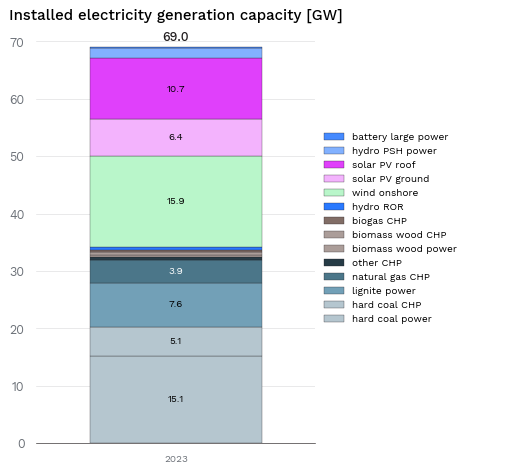

In [26]:
from pypsa_pl.plot_outputs import plot_installed_capacities

fig, df = plot_installed_capacities(network)

df = append_annual_sum(df)
df

,year,carrier,value
0,2023,battery large power,0.00
1,2023,biogas CHP,0.00
2,2023,biomass wood CHP,0.00
3,2023,biomass wood power,0.00
4,2023,hard coal CHP,0.00
5,2023,hard coal power,0.00
6,2023,hydro PSH power,0.00
7,2023,hydro ROR,0.00
8,2023,lignite power,0.00
9,2023,natural gas CHP,0.00


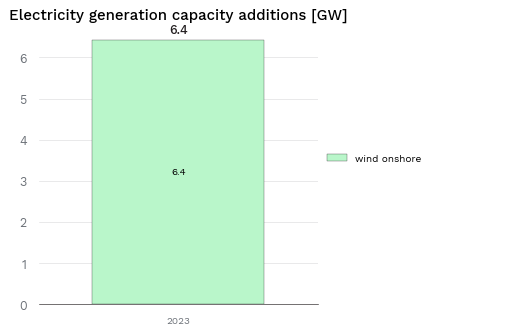

In [27]:
from pypsa_pl.plot_outputs import plot_capacity_additions

fig, df = plot_capacity_additions(network)

df = append_annual_sum(df)
df

,year,carrier,value
0,2023,battery large storage,0.60
1,2023,hydro PSH storage,8.47
0,2023,SUM,9.07


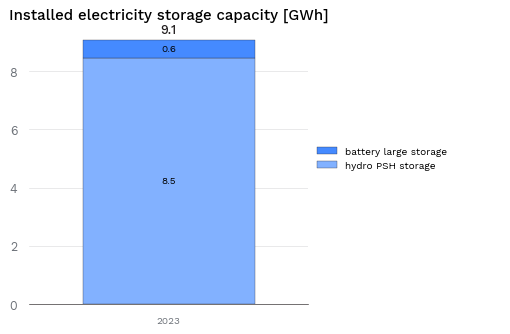

In [28]:
from pypsa_pl.plot_outputs import plot_storage_capacities, plot_storage_capacity_additions

fig, df = plot_storage_capacities(network)

df = append_annual_sum(df)
df

#### Plot electricity generation mix

,year,carrier,value
0,2023,battery large charger,-2.400000e-01
1,2023,battery large power,2.200000e-01
2,2023,biogas CHP,1.290000e+00
3,2023,biomass wood CHP,3.240000e+00
4,2023,biomass wood power,2.530000e+00
5,2023,electricity final use,-1.481000e+02
6,2023,electricity grid,-6.260000e+00
7,2023,hard coal CHP,1.435000e+01
8,2023,hard coal power,3.380000e+01
9,2023,hydro PSH power,1.330000e+00


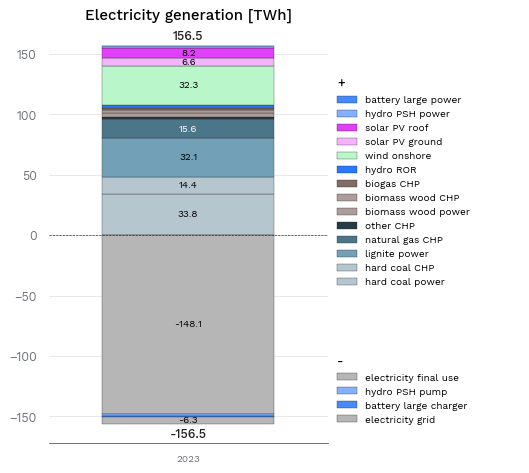

In [29]:
from pypsa_pl.plot_outputs import plot_annual_generation

fig, df = plot_annual_generation(network)

df = append_annual_sum(df)
df

#### Plot fuel consumption and CO2 emissions

,year,fuel,value
0,2023,biogas,11.3
1,2023,biomass wood,73.4
2,2023,hard coal,535.9
3,2023,lignite,331.0
4,2023,natural gas,117.7
5,2023,other fuel,25.5
0,2023,SUM,1094.8


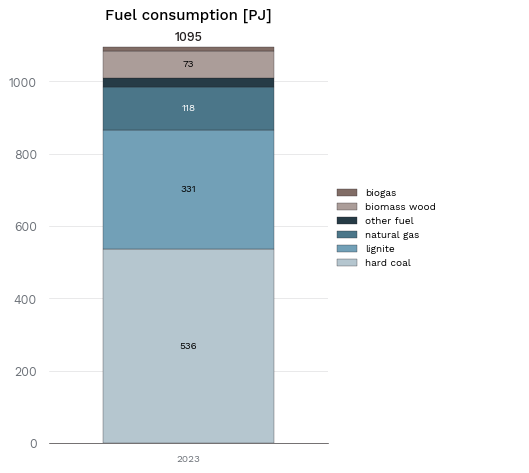

In [30]:
from pypsa_pl.plot_outputs import plot_fuel_consumption

fig, df = plot_fuel_consumption(network)

df = append_annual_sum(df)
df

,year,fuel,value
0,2023,hard coal,50.61
1,2023,lignite,36.78
2,2023,natural gas,6.54
3,2023,other fuel,1.91
0,2023,SUM,95.84


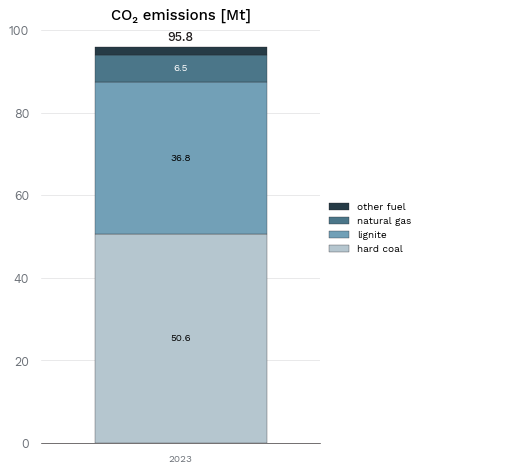

In [31]:
from pypsa_pl.plot_outputs import plot_co2_emissions

fig, df = plot_co2_emissions(network)

df = append_annual_sum(df)
df

#### Plot hourly electricity generation

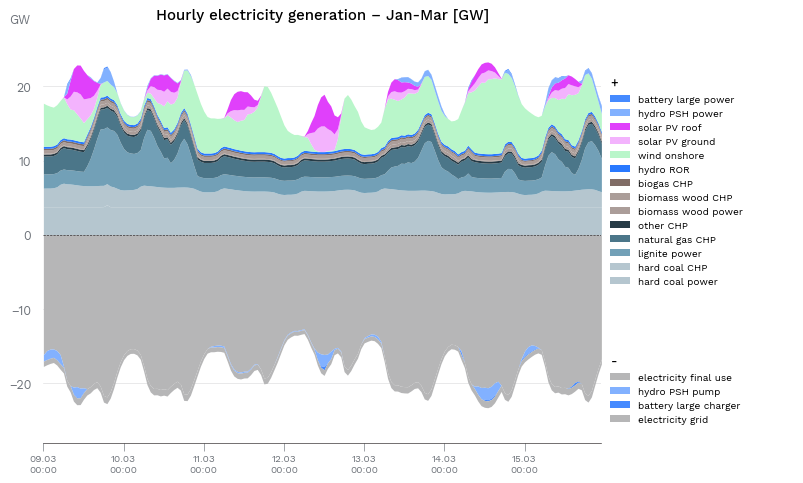

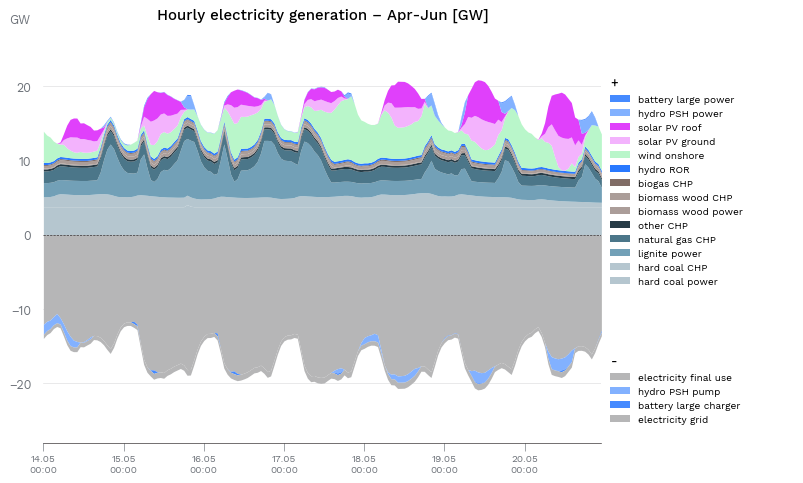

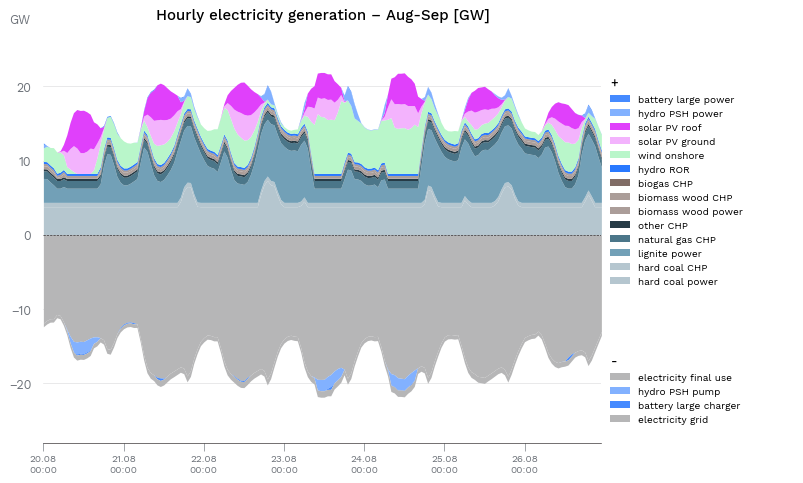

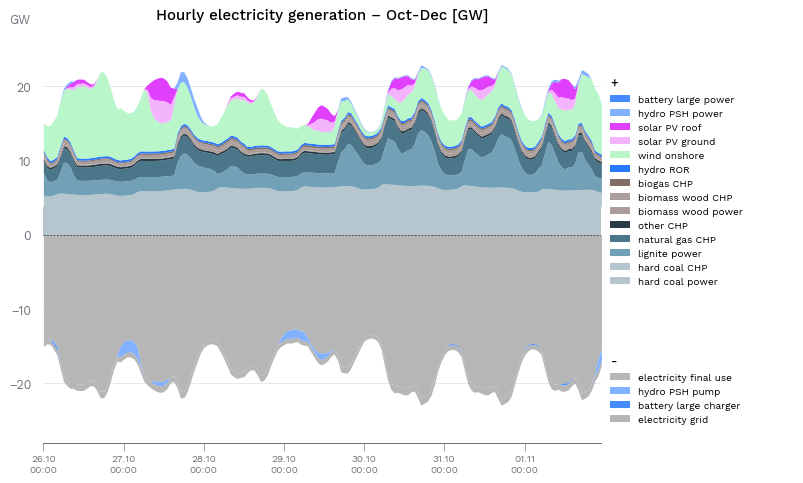

In [32]:
from pypsa_pl.plot_outputs import plot_hourly_generation

n_per_subperiod = 7 * 24
subperiods = [
    (subperiod, (i * n_per_subperiod, (i + 1) * n_per_subperiod))
    for i, subperiod in enumerate(["Jan-Mar", "Apr-Jun", "Aug-Sep", "Oct-Dec"])
]

fig, df = plot_hourly_generation(network, subperiods=subperiods, ylim=(-28, 28))

In [33]:
df

carrier,battery large charger,battery large power,biogas CHP,biomass wood CHP,biomass wood power,electricity final use,electricity grid,hard coal CHP,hard coal power,hydro PSH power,...,hydro ROR,lignite power,natural gas CHP,natural gas power,natural gas power peaker,nuclear power,other CHP,solar PV ground,solar PV roof,wind onshore
2023-03-09 00:00:00,-0.044,0.000,0.218,0.442,0.1,-16.146,-0.709,2.502,3.785,0.000,...,0.276,1.910,2.403,0.0,0.0,0.0,0.275,0.0,0.0,5.813
2023-03-09 01:00:00,-0.045,0.000,0.219,0.442,0.1,-15.588,-0.700,2.513,3.785,0.000,...,0.276,1.910,2.411,0.0,0.0,0.0,0.275,0.0,0.0,5.570
2023-03-09 02:00:00,-0.045,0.000,0.219,0.442,0.1,-15.385,-0.693,2.513,3.785,0.000,...,0.276,1.910,2.411,0.0,0.0,0.0,0.275,0.0,0.0,5.389
2023-03-09 03:00:00,-0.046,0.000,0.222,0.442,0.1,-15.368,-0.688,2.556,3.785,0.000,...,0.276,1.910,2.441,0.0,0.0,0.0,0.275,0.0,0.0,5.190
2023-03-09 04:00:00,-0.051,0.000,0.232,0.442,0.1,-15.588,-0.701,2.682,3.785,0.000,...,0.276,1.910,2.531,0.0,0.0,0.0,0.275,0.0,0.0,5.298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01 19:00:00,0.000,0.124,0.205,0.442,0.4,-20.812,-0.867,2.344,3.785,0.227,...,0.276,3.392,2.290,0.0,0.0,0.0,0.275,0.0,0.0,7.920
2023-11-01 20:00:00,0.000,0.000,0.202,0.442,0.4,-20.085,-0.837,2.312,3.785,0.000,...,0.276,2.740,2.267,0.0,0.0,0.0,0.275,0.0,0.0,8.222
2023-11-01 21:00:00,-0.070,0.000,0.195,0.442,0.1,-18.563,-0.788,2.227,3.785,0.000,...,0.276,1.910,2.207,0.0,0.0,0.0,0.275,0.0,0.0,8.271
2023-11-01 22:00:00,-0.080,0.000,0.181,0.442,0.1,-16.737,-0.759,2.047,3.785,0.000,...,0.276,1.910,2.078,0.0,0.0,0.0,0.275,0.0,0.0,7.891


#### Plot marginal cost of electricity production

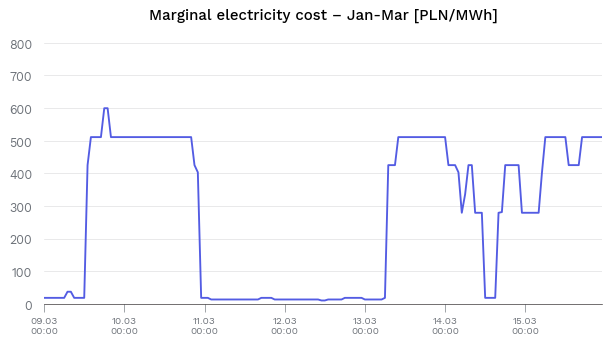

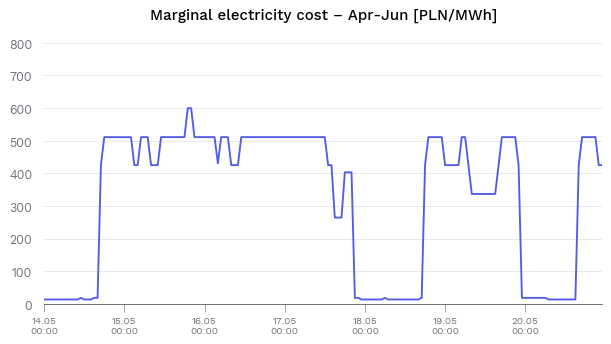

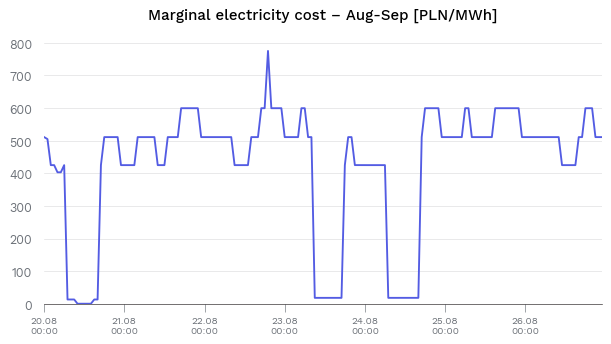

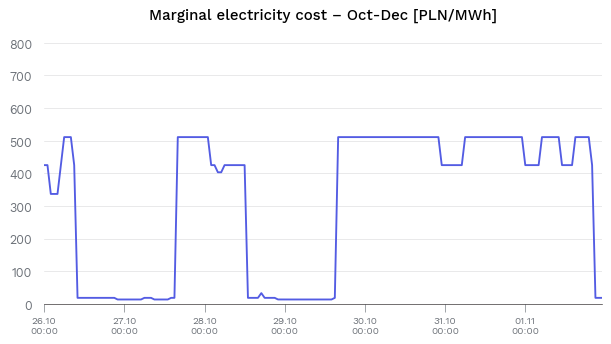

In [34]:
from pypsa_pl.plot_outputs import plot_prices

n_per_subperiod = 7 * 24
subperiods = [
    (subperiod, (i * n_per_subperiod, (i + 1) * n_per_subperiod))
    for i, subperiod in enumerate(["Jan-Mar", "Apr-Jun", "Aug-Sep", "Oct-Dec"])
]

fig, df = plot_prices(network, subperiods=subperiods, ylim=(0, 850))

df_price = df.copy()

Avg. electricity price (simple): 332.4 PLN/MWh


,metric,value
0,Avg. unit cost,584.4
1,Avg. price,352.7


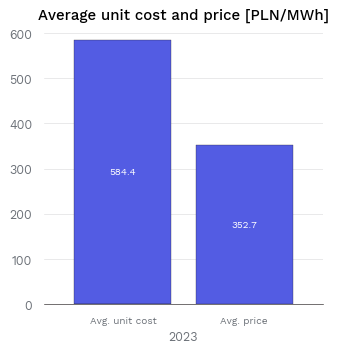

In [35]:
from pypsa_pl.plot_outputs import plot_average_unit_cost_and_price

fig, df = plot_average_unit_cost_and_price(network)

# Calculate simple (i.e. non-weighted) avg. market price
mean_price = df_price.mean().values[0].round(1)
print("Avg. electricity price (simple):", mean_price, "PLN/MWh")

df

#### Plot total overnight investment costs

,year,aggregation,value
24,2023,wind onshore,45.59
0,2023,SUM,45.59


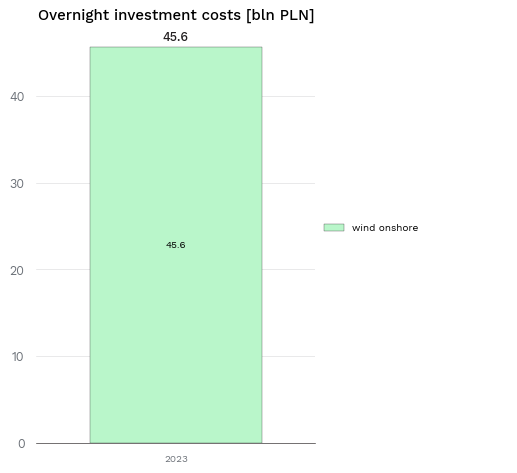

In [36]:
from pypsa_pl.plot_outputs import plot_capex

fig, df = plot_capex(network, cost_attr="investment_cost")

df = append_annual_sum(df)

df

#### Plot total annual costs

,year,aggregation,value
0,2023,battery large,0.0034
1,2023,biogas CHP,0.0780
2,2023,biogas production,0.2516
3,2023,biogas substrate supply,0.6294
4,2023,biomass CHP,0.5232
5,2023,biomass power,0.3108
6,2023,biomass supply,2.4452
9,2023,hard coal CHP,1.3684
10,2023,hard coal power,3.8554
11,2023,hard coal supply,37.0958


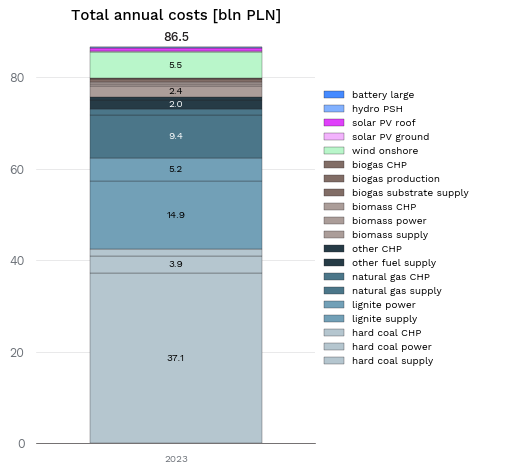

In [37]:
from pypsa_pl.plot_outputs import plot_total_costs

fig, df = plot_total_costs(network, costs=["OPEX", "CAPEX"])

df = append_annual_sum(df)

df

#### Plot annual cost structure

cost component,year,aggregation,Var. O&M,CO₂,Fix. O&M,Ann. invest.,SUM
0,2023,biogas CHP,0.06,0.00,0.02,0.00,0.08
1,2023,biogas production,0.01,0.00,0.24,0.00,0.25
2,2023,biogas substrate supply,0.63,0.00,0.00,0.00,0.63
3,2023,biomass CHP,0.09,0.00,0.43,0.00,0.52
4,2023,biomass power,0.07,0.00,0.24,0.00,0.31
5,2023,biomass supply,2.45,0.00,0.00,0.00,2.45
6,2023,hard coal CHP,0.29,0.00,1.08,0.00,1.37
7,2023,hard coal power,0.68,0.00,3.18,0.00,3.86
8,2023,hard coal supply,17.86,19.23,0.00,0.00,37.09
9,2023,hydro PSH,0.01,0.00,0.09,0.00,0.10


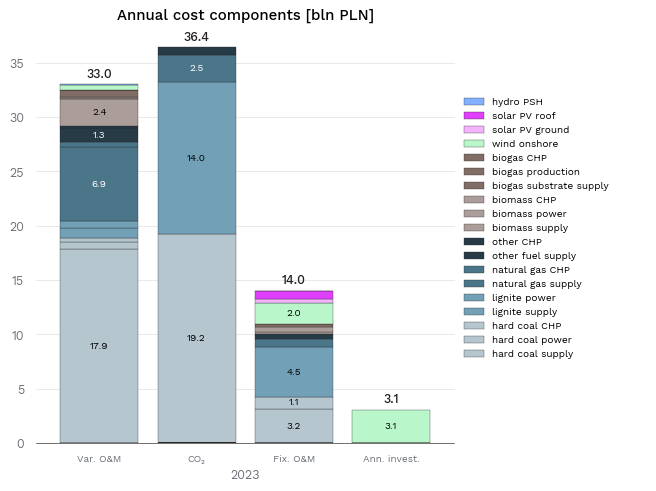

In [38]:
from pypsa_pl.plot_outputs import plot_detailed_costs

fig, df = plot_detailed_costs(network)

df = df.pivot(index="aggregation", columns="cost component", values="value").fillna(0)
columns = list(df.columns)

df["SUM"] = df.sum(axis=1)
df = df.reset_index().assign(year=params["year"])
df = append_annual_sum(df, value_cols=columns+["SUM"])
df = df.set_index(["year", "aggregation"]).reset_index()

df

### Sensitivity analysis: cost assumptions

In [39]:
import logging
import numpy as np
from matplotlib import pyplot as plt
from io import BytesIO
import ipywidgets as widgets
from ipywidgets import interact_manual

from pypsa_pl.helper_functions import suppress_stdout
from pypsa_pl.mathematical_operations import calculate_annuity

In [40]:
default_p_min_pu = 0.25

def update_p_min_pu_of_public_power_plants(network, p_min_pu=default_p_min_pu):
    is_public_pp = network.links["carrier"].isin(
        ["hard coal power", "lignite power", "biomass wood power"]
    ) & (network.links["qualifier"] == "public")
    if network.meta["reverse_links"]:
        network.links.loc[is_public_pp, "p_max_pu"] = -p_min_pu
    else:
        network.links.loc[is_public_pp, "p_min_pu"] = p_min_pu
    return network

In [41]:
eur_to_pln = 4.54  # 2023 exchange rate
default_co2_price = 83  # in EUR/tCO2

def update_co2_costs(network, co2_price=default_co2_price):
    co2_price_pln = round(co2_price * eur_to_pln, -1)
    logging.info(f"Setting CO2 price to {co2_price_pln} PLN/tCO2")

    fossil_carriers = [
        "hard coal supply",
        "lignite supply",
        "natural gas supply",
        "other fuel supply",
    ]
    is_fossil_supply = network.generators["carrier"].isin(fossil_carriers)
    co2_cost = (
        network.carriers.loc[fossil_carriers, "co2_emissions"] * co2_price_pln
    ).rename("co2_cost")
    co2_cost = pd.merge(
        network.generators.loc[is_fossil_supply, "carrier"],
        co2_cost,
        left_on="carrier",
        right_index=True,
        how="left",
    )["co2_cost"]

    network.generators.loc[is_fossil_supply, "co2_cost"] = co2_cost
    network.generators["marginal_cost"] = (
        network.generators["co2_cost"] + network.generators["variable_cost"]
    )

In [42]:
for component in ["Generator", "Link", "Store"]:
    network.df(component)["default_investment_cost"] = network.df(component)[
        "investment_cost"
    ]

default_discount_rate = params["discount_rate"]


def update_investment_costs(
    network,
    wind_solar_cost_factor=1,
    battery_cost_factor=1,
    nuclear_cost_factor=1,
):
    is_wind_or_solar = network.generators["carrier"].str.startswith(
        ("wind", "solar PV")
    )
    network.generators.loc[is_wind_or_solar, "investment_cost"] = (
        wind_solar_cost_factor
        * network.generators.loc[is_wind_or_solar, "default_investment_cost"]
    )
    is_battery_link = network.links["carrier"].str.startswith("battery")
    network.links.loc[is_battery_link, "investment_cost"] = (
        battery_cost_factor
        * network.links.loc[is_battery_link, "default_investment_cost"]
    )
    is_battery_store = network.stores["carrier"].str.startswith("battery")
    network.stores.loc[is_battery_store, "investment_cost"] = (
        battery_cost_factor
        * network.stores.loc[is_battery_store, "default_investment_cost"]
    )
    is_nuclear = network.generators["carrier"].str.startswith("nuclear")
    network.generators.loc[is_nuclear, "investment_cost"] = (
        nuclear_cost_factor
        * network.generators.loc[is_nuclear, "default_investment_cost"]
    )


def update_discount_rate(network, params, discount_rate=default_discount_rate):
    params["discount_rate"] = discount_rate
    for component in ["Generator", "Link", "Store"]:
        has_investment_cost = network.df(component)["lifetime"] > 1
        network.df(component).loc[
            has_investment_cost, "annual_investment_cost"
        ] = network.df(component).loc[
            has_investment_cost, "investment_cost"
        ] * calculate_annuity(
            lifetime=network.df(component).loc[has_investment_cost, "lifetime"],
            discount_rate=discount_rate,
        )
        network.generators["capital_cost"] = (
            network.generators["fixed_cost"]
            + network.generators["annual_investment_cost"]
        )

In [43]:
default_investment_technologies = [
    tech
    for tech in params["investment_technologies"]
    if tech
    not in ["battery large power", "battery large charger", "battery large storage"]
] + ["battery large"]
default_retirement_technologies = params["retirement_technologies"]


def update_extendability(
    network,
    params,
    investment_technologies=default_investment_technologies,
    retirement_technologies=default_retirement_technologies,
):

    if "battery large" in investment_technologies:
        investment_technologies = investment_technologies + [
            "battery large power",
            "battery large charger",
            "battery large storage",
        ]

    params["investment_technologies"] = investment_technologies
    params["retirement_technologies"] = retirement_technologies

    for component, nom_attr in [
        ("Generator", "p_nom"),
        ("Link", "p_nom"),
        ("Store", "e_nom"),
    ]:
        is_to_invest = network.df(component)["technology"].isin(investment_technologies)
        is_to_retire = network.df(component)["technology"].isin(retirement_technologies)
        network.df(component)[f"{nom_attr}_extendable"] = is_to_invest | is_to_retire

        network.df(component)[f"{nom_attr}_min"] = network.df(component)[nom_attr]
        network.df(component)[f"{nom_attr}_max"] = network.df(component)[nom_attr]

        is_cumulative = network.df(component)["lifetime"] == 1
        is_active = network.df(component)["build_year"] == network.meta["year"]

        network.df(component).loc[
            is_to_invest & ~is_cumulative & is_active, f"{nom_attr}_max"
        ] = np.inf
        network.df(component).loc[
            is_to_retire & is_cumulative & is_active, f"{nom_attr}_min"
        ] = 0

In [44]:
from pypsa_pl.plot_outputs import plot_curtailed_vres_energy

n_per_subperiod = 7 * 24
subperiods = [
    (subperiod, (i * n_per_subperiod, (i + 1) * n_per_subperiod))
    for i, subperiod in enumerate(["Jan-Mar", "Apr-Jun", "Aug-Sep", "Oct-Dec"])
]

figure_width = 7


def list_plotting_tasks():
    return [
        (
            plot_hourly_generation,
            dict(subperiods=[subperiods[1]], ylim=(-31, 31), figsize=(figure_width, 6)),
        ),
        (
            plot_prices,
            dict(subperiods=[subperiods[1]], ylim=(0, 1250), figsize=(figure_width, 4)),
        ),
        (
            plot_installed_capacities,
            dict(ylim=(0, 115), figsize=(figure_width, 6)),
        ),
        (
            plot_capacity_additions,
            dict(ylim=(-35, 75), figsize=(figure_width, 4)),
        ),
        (
            plot_storage_capacities,
            dict(ylim=(0, 65), figsize=(figure_width, 4)),
        ),
        (
            plot_storage_capacity_additions,
            dict(ylim=(0, 65), figsize=(figure_width, 4)),
        ),
        (
            plot_annual_generation,
            dict(ylim=(-205, 205), figsize=(figure_width, 6)),
        ),
        (
            plot_curtailed_vres_energy,
            dict(ylim=(0, 45), figsize=(figure_width, 4)),
        ),
        (
            plot_co2_emissions,
            dict(ylim=(0, 115), figsize=(figure_width, 5)),
        ),
        (
            plot_total_costs,
            dict(ylim=(0, 145), figsize=(figure_width, 6)),
        ),
        (
            plot_detailed_costs,
            dict(ylim=(0, 85), figsize=(figure_width, 6)),
        ),
        (
            plot_capex,
            dict(cost_attr="investment_cost", ylim=(0, 510), figsize=(figure_width, 5)),
        ),
        (
            plot_average_unit_cost_and_price,
            dict(ylim=(0, 1250), figsize=(figure_width, 4)),
        ),
    ]

In [45]:
def make_images(network):
    imgs = []
    for plot_func, kwargs in list_plotting_tasks():
        try:
            fig, _ = plot_func(network, **kwargs)
            img = BytesIO()
            fig.tight_layout()
            px_per_inch = 85
            fig.savefig(img, format="png", dpi=px_per_inch * 2)
            plt.close()
            img.seek(0)
            img = widgets.Image(value=img.read(), format="png")
            width, height = kwargs["figsize"]
            img.layout = widgets.Layout(
                height=f"{px_per_inch*height}px",
                width=f"{px_per_inch*width}px",
                margin="5px 5px 5px 5px",
                border="solid 1.5px darkgrey",
            )
            imgs.append(img)
        except:
            logging.warning(f"Failed to create image with '{plot_func.__name__}'")
    return imgs


def make_widgets(values, images):
    header_layout = widgets.Layout(
        min_height="480px",
        border="solid 1.5px darkgrey",
        margin="5px 5px 5px 5px",
        padding="5px 5px 5px 5px",
    )
    column_layout = widgets.Layout(
        margin="10px 5px 10px 5px",
        padding="5px 5px 5px 5px",
    )
    columns = []
    for key in ["previous", "current"]:
        html = f"""
            <center>
                <div><b>{key.upper()} CALCULATION</b></div>
                <div>p_min_pu: {values[key]['p_min_pu']:.0%}</div>
                <div>co2_price: {values[key]['co2_price']:.0f} EUR/tCO2</div>
                <div>wind_solar_cost_factor: {values[key]['wind_solar_cost_factor']:.0%}</div>
                <div>battery_cost_factor: {values[key]['battery_cost_factor']:.0%}</div>
                <div>nuclear_cost_factor: {values[key]['nuclear_cost_factor']:.0%}</div>
                <div>discount_rate: {values[key]['discount_rate']:.0%}</div>"""
        if values[key]["investment_technologies"]:
            html += f"""
                <div>investment_technologies:
                    <div style="line-height:1">
                    {'<br>'.join('• ' + tech for tech in values[key]['investment_technologies'])}<br><br>
                    </div>
                </div>"""
        if values[key]["retirement_technologies"]:
            html += f"""
                <div>retirement_technologies:
                    <div style="line-height:1">
                    {'<br>'.join('• ' + tech for tech in values[key]['retirement_technologies'])}<br><br>
                    </div>
                </div>"""
        html += f"""
            </center>"""
        header = widgets.HTML(value=html)
        header.layout = header_layout
        column = widgets.VBox([header] + images[key])
        column.layout = column_layout
        columns.append(column)

    return widgets.HBox(columns)

In [46]:
disallow_retirements = True

values = {
    "previous": None,
    "current": {
        "p_min_pu": default_p_min_pu,
        "co2_price": default_co2_price,
        "wind_solar_cost_factor": 1,
        "battery_cost_factor": 1,
        "nuclear_cost_factor": 1,
        "discount_rate": default_discount_rate,
        "investment_technologies": default_investment_technologies,
        "retirement_technologies": default_retirement_technologies,
    },
}
images = {"previous": None, "current": make_images(network)}


@interact_manual(
    p_min_pu=widgets.FloatSlider(default_p_min_pu, min=0, max=0.301, step=0.01),
    co2_price=widgets.FloatSlider(default_co2_price, min=0, max=180.01, step=1),
    wind_solar_cost_factor=widgets.FloatSlider(1, min=0.5, max=1.501, step=0.05),
    battery_cost_factor=widgets.FloatSlider(1, min=0.5, max=1.501, step=0.05),
    nuclear_cost_factor=widgets.FloatSlider(1, min=0.5, max=1.501, step=0.05),
    discount_rate=widgets.FloatSlider(
        default_discount_rate, min=0, max=0.101, step=0.005, readout_format=".3f"
    ),
    investment_technologies=widgets.SelectMultiple(
        value=default_investment_technologies,
        options=[
            "wind onshore",
            "solar PV ground",
            "nuclear power large",
            "natural gas power CCGT",
            "natural gas power peaker",
            "hard coal power SC",
            "lignite power SC",
            "battery large",
        ],
        rows=8,
    ),
    retirement_technologies=widgets.SelectMultiple(
        value=default_retirement_technologies,
        options=[
            "hard coal power old",
            "lignite power old",
            "hard coal power SC",
            "lignite power SC",
            "biomass wood power",
        ],
        rows=5,
    ),
)
def recalculate(
    p_min_pu,
    co2_price,
    wind_solar_cost_factor,
    battery_cost_factor,
    nuclear_cost_factor,
    discount_rate,
    investment_technologies,
    retirement_technologies,
):

    if disallow_retirements and p_min_pu > 0 and len(retirement_technologies) > 0:
        logging.error(
            "Allowing retirement of conventional power plants with forced operation (p_min_pu > 0)"
            + " might generate misleading results. It is so because similar forced operation is not"
            + " required for investment candidate units. Assume high flexibility of conventional"
            + " power plants (p_min_pu = 0) or set 'disallow_retirements' variable to False."
        )
        return

    values["previous"] = values["current"]
    images["previous"] = images["current"]

    update_p_min_pu_of_public_power_plants(network, p_min_pu)
    update_co2_costs(network, co2_price)
    update_investment_costs(
        network, wind_solar_cost_factor, battery_cost_factor, nuclear_cost_factor
    )
    update_discount_rate(network, params, discount_rate)
    update_extendability(
        network, params, list(investment_technologies), list(retirement_technologies)
    )

    network.meta = params
    with suppress_stdout():
        optimise_network(network, params)

    logging.info("Generating result visualisations...")

    values["current"] = {
        "p_min_pu": p_min_pu,
        "co2_price": co2_price,
        "wind_solar_cost_factor": wind_solar_cost_factor,
        "battery_cost_factor": battery_cost_factor,
        "nuclear_cost_factor": nuclear_cost_factor,
        "discount_rate": discount_rate,
        "investment_technologies": list(investment_technologies),
        "retirement_technologies": list(retirement_technologies),
    }
    images["current"] = make_images(network)

    return make_widgets(values, images)

interactive(children=(FloatSlider(value=0.25, description='p_min_pu', max=0.301, step=0.01), FloatSlider(value…